## Objective:<br>
The analysis target to use text to predict the comment in reddit to be removed or not <br>
 
#### Part 1. Draw a baseline for simple regression classifier   <br>
    - the data showing imbalance sample issue -- fix by downsampling
    - the outcome showing overfitting with high accuracy(80%) for train and (69%) for test<br>
#### Part 2. Model building and tuning <br>
Methods with simple normalization <br>
    - Tf-idf, 
    - n-gram
    - characters/words as unit token
    - change the threshold : min_df, max_feature, stop_words, and scaling  
    - Using different encodding to deal with foreigh words/characters
Latent semantic analysis with dimention reduction techniques:  <br>
    - SVD 
    - LDA  
Refining the model by adding derived features <br>
    - Length of the comment
    - Whether it include a website, what website is included
    - whether include number
    - Number of non-english words, etc.
#### Part 3. <br>
Using existing word dictionary to distill the corpus <br>
    - Gensim corpora output is tuple and can not be applied to TF-IDF vectorizer
    - Build a customized tokenizer, leave only words after lematization that is in the corpora word dictionary
    - Use trained Word2Vec directly, the model could be another baseline model

### Conclusion:<br>
The analysis focused on modeling text and predicting the item got removed from the stream or not 
Words/Features closely associated with the result 
  - comments with 'Upvote', 'Feminist' (discriminated word), words that is not polite are highly associated with deleting
  - comments with 'Edit', 'Recommends', and words related to research terminology are associated to not deleting

To yeild better predictive power
  - More cleaning, derive new features on the text, fine tuning on model help providing better insights of what the characteristics of the comments that got removed.  
  - However, not necessary to yield better result. 
  - Dimension reduction (SVD) will also provide a good result given the less space and computing power it take 
  - Leveraging existing trained model Word2Vec could also serve as a baseline

### Part 1. Understand data, and build baseline model

In [ ]:
# data manipulation
import re

import numpy as np
import pandas as pd
from scipy import sparse
# plot
from matplotlib import pyplot as plt

# %% pre processing, text feature extraction

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer

# pipeline
from sklearn.pipeline import Pipeline

# model evaluation
from sklearn.metrics import classification_report
# %%modeling and model selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [1]:
#%%
data_train=pd.read_csv("reddit_200k_train.csv",encoding='iso-8859-1')
data_train.shape

(167529, 8)

In [2]:
data=data_train[['body','REMOVED']]
data['REMOVED'].value_counts()

False    102791
True      64738
Name: REMOVED, dtype: int64

In [3]:
# Deal with Imbalanced sample issue by downsampling
rus = RandomUnderSampler(replacement=False)
train_X_subsample, train_y_subsample = rus.fit_sample(
    data_train[['body']], data[['REMOVED']])

In [4]:
pd.Series(train_y_subsample.ravel()).value_counts()

True     64738
False    64738
dtype: int64

In [68]:
vect=CountVectorizer()
vect.fit(train_X_subsample.ravel())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [28]:
#%% use n-gram
 
vect=CountVectorizer()
vect.fit(train_X_subsample.ravel())
#print(vect.get_feature_names()[::2000])
print('total number of tokens {}'.format(len(vect.get_feature_names())))
#total number of tokens 39786
#%% need to transform prior to the regression
vect_trans=vect.transform(train_X_subsample.ravel())
print('initial raw vector shape is {}'.format(vect_trans.shape))
#%%

X_train,X_test,y_train,y_test=train_test_split(vect_trans,train_y_subsample)
#%% A basic model for this

 
lr_base=LogisticRegression().fit(X_train,y_train)
print(classification_report(y_train,lr_base.predict(X_train)))
print(classification_report(y_test,lr_base.predict(X_test)))

total number of tokens 93505
initial raw vector shape is (129476, 93505)


C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

       False       0.85      0.73      0.79     48507
        True       0.76      0.87      0.82     48600

    accuracy                           0.80     97107
   macro avg       0.81      0.80      0.80     97107
weighted avg       0.81      0.80      0.80     97107

              precision    recall  f1-score   support

       False       0.72      0.61      0.66     16231
        True       0.66      0.76      0.71     16138

    accuracy                           0.69     32369
   macro avg       0.69      0.69      0.69     32369
weighted avg       0.69      0.69      0.69     32369



The base model is a good example of over fitting, this issue might be solved by regularization <br>
For more accurate result, building pipline for the following analysis <br>

### Part 2. Scale by Tfidf
-  using n-gram
-  adding restriction of apprearing in 10+ documents in the corpus
-  use pipeline to normalize training and testing separately to avoid data leakage

In [70]:
vect = CountVectorizer(stop_words='english',token_pattern=r'\b[^\d\W]+\b', min_df=10).fit(train_X_subsample.ravel())

X_CV = vect.fit_transform(train_X_subsample.ravel())

X_train,X_test,y_train,y_test=train_test_split(X_CV,train_y_subsample)

lr_base2 = LogisticRegression().fit(X_train,y_train)

In [72]:
print(classification_report(y_train,lr_base2.predict(X_train)))
print(classification_report(y_test,lr_base2.predict(X_test)))

              precision    recall  f1-score   support

       False       0.81      0.68      0.74     48348
        True       0.73      0.84      0.78     48759

    accuracy                           0.76     97107
   macro avg       0.77      0.76      0.76     97107
weighted avg       0.77      0.76      0.76     97107

              precision    recall  f1-score   support

       False       0.72      0.59      0.65     16390
        True       0.65      0.77      0.70     15979

    accuracy                           0.68     32369
   macro avg       0.68      0.68      0.68     32369
weighted avg       0.69      0.68      0.68     32369



In [55]:
lr_base_tfidf = Pipeline([
    ("tfidf",TfidfTransformer()),
    ("lr", LogisticRegression(penalty='l1'))])
lr_base_tfidf.fit(X_train,y_train)
print(classification_report(y_train,lr_base_tfidf.predict(X_train)))
print(classification_report(y_test,lr_base_tfidf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.76      0.66      0.71     48348
        True       0.70      0.80      0.75     48759

    accuracy                           0.73     97107
   macro avg       0.73      0.73      0.73     97107
weighted avg       0.73      0.73      0.73     97107

              precision    recall  f1-score   support

       False       0.73      0.62      0.67     16390
        True       0.66      0.77      0.71     15979

    accuracy                           0.69     32369
   macro avg       0.70      0.69      0.69     32369
weighted avg       0.70      0.69      0.69     32369



the result is slightly better after normalization and regularization

- check important word to determine the model

In [54]:
lr_base_tfidf

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [52]:
#%% define the function to show the important word
from nlp_plotting import plot_important_features
"""
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]
    
    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")
"""

In [67]:
feature_names.shape#= np.array(vect.get_feature_names())

(15167,)

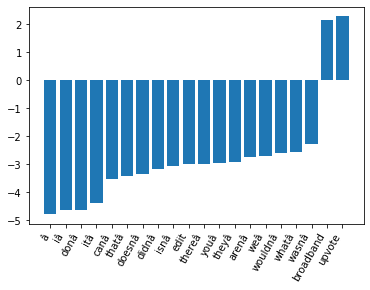

In [73]:
#%% plot the top feature in the classifier
feature_names = np.array(vect.get_feature_names())
n_components = 10
#fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
coef=lr_base2.coef_.ravel()
plot_important_features(coef, feature_names, top_n=20, ax=None)
# we can see that there are a lot of non-english letter words that doniment the negative top identifier
# this might be the issue that the negative recall rate is so low
# should fix this 

In [74]:
# by first encode and then decode, remove all non-english characteristics and make the result more interpretable and meaningful

body_clean=pd.DataFrame(train_X_subsample.ravel())[0].apply(lambda x:x.lower().encode("ascii", errors="ignore").decode())
 

vect=CountVectorizer(stop_words='english',token_pattern=r'\b[^\d\W]+\b',
                     ngram_range=(1, 4), analyzer='word',  min_df=10)
vect.fit(body_clean)
print(vect.get_feature_names()[::2000])
print('total number of tokens {}'.format(len(vect.get_feature_names())))
#total number of tokens 39786
#%% need to transform prior to the regression
vect_trans=vect.transform(body_clean)
print(vect_trans.shape)
#%%

X_train,X_test,y_train,y_test=train_test_split(vect_trans,data['REMOVED'])
#%% A basic model for this 
lr_3_englishletteronly=LogisticRegression().fit(X_train,y_train)

['_', 'article science', 'bros', 'combined', 'decide s', 'downhill', 'factor analysis', 'godsend', 'hills', 'interpretations', 'left', 'm sure s', 'multicellular', 'overall results', 'pmc articles', 'randomized controlled', 'routinely', 'self identified', 'stephanie', 't taste', 'transcranial magnetic', 'wasn t big']
total number of tokens 43780
(167529, 43780)


C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [114]:
l=[len(x.split(' ')) for x in vect.get_feature_names()]

In [115]:
pd.Series(l).value_counts()

2    21465
1    17949
3     3169
4     1197
dtype: int64

- with mind_df restriction, the length of the feature could not be longer than 4 in this case

In [75]:
print(classification_report(y_train,lr_3_englishletteronly.predict(X_train)))
print(classification_report(y_test,lr_3_englishletteronly.predict(X_test)))

              precision    recall  f1-score   support

       False       0.78      0.85      0.81     77145
        True       0.72      0.62      0.67     48501

    accuracy                           0.76    125646
   macro avg       0.75      0.74      0.74    125646
weighted avg       0.76      0.76      0.76    125646

              precision    recall  f1-score   support

       False       0.71      0.78      0.74     25646
        True       0.59      0.50      0.54     16237

    accuracy                           0.67     41883
   macro avg       0.65      0.64      0.64     41883
weighted avg       0.66      0.67      0.67     41883



 - clean up the words does not improve the accuracy but do improve the interpretability of the model:

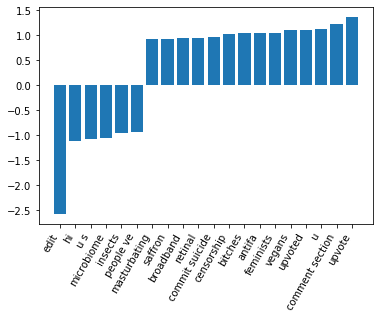

In [76]:

feature_names = np.array(vect.get_feature_names())
n_components = 10
#fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
coef=lr_3_englishletteronly.coef_.ravel()
plot_important_features(coef, feature_names, top_n=20, ax=None)
# the result makes more sense 
# i.e. "upvote" might not have any meaningful contribution thus got deleted
# should think of remain the original data or clean in some other way

In [95]:
X_train,X_test,y_train,y_test=train_test_split(train_X_subsample.ravel(),train_y_subsample)

In [96]:
lr_grid = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("lr", LogisticRegression())])

# run grid search for parameter tuning
 
parameters = {
    'lr__C':(1,0.1,0.04,0.07),
    'lr__penalty':('l2','l1'),
    'tfidf__min_df':(10,5)
    
}
 
grid_search = GridSearchCV(lr_grid, parameters, cv=5,
                               n_jobs=-1, verbose=1 ,refit='f1')
grid_search.fit(X_train,y_train)
print(classification_report(y_train,grid_search.predict(X_train)))
print(classification_report(y_test,grid_search.predict(X_test)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.7min finished
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       False       0.78      0.71      0.74     48610
        True       0.73      0.79      0.76     48497

    accuracy                           0.75     97107
   macro avg       0.75      0.75      0.75     97107
weighted avg       0.75      0.75      0.75     97107

              precision    recall  f1-score   support

       False       0.71      0.65      0.68     16128
        True       0.68      0.74      0.71     16241

    accuracy                           0.70     32369
   macro avg       0.70      0.70      0.70     32369
weighted avg       0.70      0.70      0.70     32369



In [97]:
grid_search.best_params_

{'lr__C': 1, 'lr__penalty': 'l2', 'tfidf__min_df': 5}

- use the above for the following analysis

### Part 3. Adding more feature to the model

In [5]:
# testing the url function
def find_url_test(t):
    url=re.findall('http[s]?://(.+)[\'\(\)\s,]+',t)
    return url
l=[]
for i in data['body'][:10]:
    s=find_url_test(i)
    if s:
        print(i)
        print(s)
        l.extend(s)
# the logic could gather 

So when we can remember a history where he shared a [certain dinner](http://www.huffingtonpost.co.uk/2012/07/02/stephen-hawking-time-travel_n_1643488.html) with Stephen Hawking we'll know it worked.
["www.huffingtonpost.co.uk/2012/07/02/stephen-hawking-time-travel_n_1643488.html) with Stephen Hawking we'll know it"]
Hi BocceBaller42, your post has been removed for the following reason(s)

It has a sensationalized, editorialized, or biased headline. 
 
*If you feel this was done in error, or would like further clarification, please don't hesitate to [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;message=My%20Post:%20https://www.reddit.com/r/science/comments/5r1nu1/study_finds_evidence_that_the_universe_is_a/).*
['www.reddit.com/message/compose?to=%2Fr%2FScience&amp;message=My%20Post:%20https://www.reddit.com/r/science/comments/5r1nu1/study_finds_evidence_that_the_universe_is_a/']


In [6]:

def find_nonEng(t):
    num=re.findall('[^\x00-\x7F]+',t)
    return len(num)

len_noneng=pd.DataFrame(train_X_subsample.ravel())[0].apply(lambda x:find_nonEng(x)) 


In [7]:
def find_url(t):
    url=re.findall('http[s]?://(.+)[\'\(\)\s,]+',t)
    return len(url)

url_feature=pd.DataFrame(train_X_subsample.ravel())[0].apply(lambda x:find_url(x)) 

def find_num(t):
    num=re.findall('[a-z]*[0-9]+',t)
    return len(num)
 
num_feature=pd.DataFrame(train_X_subsample.ravel())[0].apply(lambda x: find_num(x))  

def find_nonEng(t):
    num=re.findall('[^\x00-\x7F]+',t)
    return len(num)

len_noneng=pd.DataFrame(train_X_subsample.ravel())[0].apply(lambda x:find_nonEng(x)) 

#%% add feature as the length of the string
len_string=pd.DataFrame(train_X_subsample.ravel())[0].apply(lambda x:len(x.strip().split(" ")))



In [12]:
add_feature=pd.concat( [url_feature,num_feature,len_noneng,len_string],axis=1)
add_feature.columns=[ 'url_feature','num_feature','len_noneng','len_string']

In [13]:
add_feature.head()

,url_feature,num_feature,len_noneng,len_string
0,0,0,0,17
1,0,0,0,54
2,1,8,0,59
3,0,0,0,33
4,0,0,0,59


In [15]:
vect=TfidfVectorizer(stop_words='english',token_pattern=r'\b[^\d\W]+\b',
                     ngram_range=(1, 4), analyzer='word',  min_df=5).fit_transform(train_X_subsample.ravel())


In [22]:
vect.ndim

2

In [21]:
add_feature.ndim

2

In [24]:
vect_add_feature=sparse.hstack((vect,add_feature))

In [25]:
X_train,X_test,y_train,y_test=train_test_split(vect_add_feature,train_y_subsample)

In [26]:

lr_addfeature=LogisticRegression(penalty='l2',C=1).fit(X_train,y_train)
print(classification_report(y_train,lr_addfeature.predict(X_train)))
print(classification_report(y_test,lr_addfeature.predict(X_test)))

C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       False       0.82      0.74      0.78     48569
        True       0.77      0.84      0.80     48538

    accuracy                           0.79     97107
   macro avg       0.79      0.79      0.79     97107
weighted avg       0.79      0.79      0.79     97107

              precision    recall  f1-score   support

       False       0.72      0.65      0.69     16169
        True       0.68      0.75      0.71     16200

    accuracy                           0.70     32369
   macro avg       0.70      0.70      0.70     32369
weighted avg       0.70      0.70      0.70     32369



- additional feature improved the accuracy for the model

- add character n-gram to enhance the model

In [27]:
# char n gram vectorizer
new_charc_vect = CountVectorizer(stop_words='english',ngram_range=(1,3),min_df=5,analyzer="char_wb")
X_char_vect = new_charc_vect.fit_transform(train_X_subsample.ravel())

In [28]:
vect_add_feature_2=sparse.hstack((vect,X_char_vect,add_feature))

In [29]:
X_train,X_test,y_train,y_test=train_test_split(vect_add_feature_2,train_y_subsample)
lr_addfeature=LogisticRegression(penalty='l2',C=1).fit(X_train,y_train)
print(classification_report(y_train,lr_addfeature.predict(X_train)))
print(classification_report(y_test,lr_addfeature.predict(X_test)))

C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

       False       0.79      0.66      0.72     48458
        True       0.71      0.82      0.76     48649

    accuracy                           0.74     97107
   macro avg       0.75      0.74      0.74     97107
weighted avg       0.75      0.74      0.74     97107

              precision    recall  f1-score   support

       False       0.75      0.62      0.68     16280
        True       0.68      0.79      0.73     16089

    accuracy                           0.71     32369
   macro avg       0.71      0.71      0.71     32369
weighted avg       0.71      0.71      0.70     32369



- the best result so far, accuracy for test is 0.71
- This combined n-gram and word countvectorization, adding features, and tuning logistic regression model

### Part 4. Reduce the dimention to see how it affect the precision of the prediction
- Latent sematic analysis with 
  - SVD
  - LDA

In [135]:
#%% Singular Value Decomposition
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=200)
X_lsa = lsa.fit_transform(vect)
lsa.components_.shape
text_tfidf.shape
X_lsa.shape
type(X_lsa)

numpy.ndarray

In [ ]:
#%% run simple SVD
plt.semilogy(lsa.explained_variance_ratio_)

In [27]:
#%% normalize the tfidf before dimention reduction with SVD
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(text_tfidf)
lsa_scaled = TruncatedSVD(n_components=200)
X_lsa_scaled = lsa_scaled.fit_transform(X_scaled)

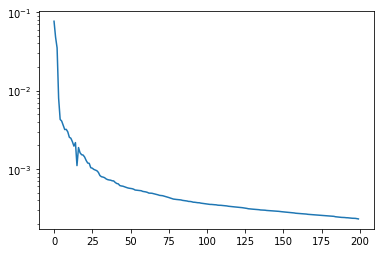

In [28]:
# check how much variance is captured by the nth SVD feature extracted
plt.semilogy(lsa_scaled.explained_variance_ratio_)

In [30]:
X_lsa_pd=pd.DataFrame(X_lsa_scaled)
comb_x=pd.concat([X_lsa_pd ,add_feature],axis=1)

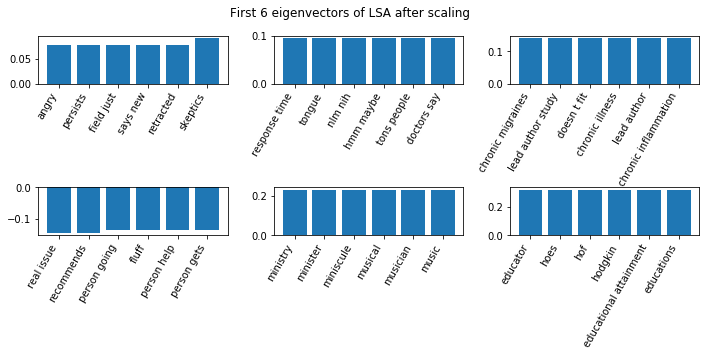

In [34]:
 
n_components = 6
fig, axes = plt.subplots(n_components // 3, 3, figsize=(10, 5))
 
for ax, coef in zip(axes.ravel(), lsa_scaled.components_):
    plot_important_features(coef, feature_names, top_n=n_components, ax=ax)
    
plt.suptitle("First 6 eigenvectors of LSA after scaling")
plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.savefig("lsa_six_eigvec_scaled.png")

- LDA can to some extend group related words together

In [74]:
vect=CountVectorizer(stop_words='english',token_pattern=r'\b[^\d\W]+\b',
                     ngram_range=(1, 4), analyzer='word',  min_df=10)
vect.fit(body_clean)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=10,
                ngram_range=(1, 4), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='\\b[^\\d\\W]+\\b',
                tokenizer=None, vocabulary=None)

In [78]:
vect_df=vect.fit_transform(body_clean)

In [79]:
# using LDA to see the topic 
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch")
X_lda = lda.fit_transform(vect_df)

feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lda.components_):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()

- lda should be done in a more cleaner version of text  
- this tokenizer does not work really well for this case  

### Part 5. Leveraging existing word embedding 
- package gensim corpra provide an existing library with English words. 
- use trained Word2Vec model directly (GoogleNews-vectors)

#### 5a. Transform text to tuple with Gensim corpra

In [30]:
import gensim

In [42]:
array_of_text=body_clean.tolist()

In [43]:
array_of_text[:10]

['so.... does this mean that fitter people choose walkable neighborhoods? or do walkable neighborhoods make people fitter?',
 'words a cared about way to much these days. gratitude is something that can be conveyed non-verbally. it also means a hell of a lot more if their actions tell you they appreciate it rather than some phrase said usually to avoid coming off rude. look at what people do, not what they say. ',
 "hi abhshek799999, your submission has been removed for the following reason(s)\r\n\r\nit has has been removed temporarily due to a lack of citations. please add a comment with a direct link to the original research, then message the moderators for reapproval\r\n\r\n\r\n\r\n*if you feel this was done in error, or would like further clarification, please don't hesitate to [message the mods](http://www.reddit.com/message/compose?to=%2fr%2fscience&amp;message=my%20post:%20https://www.reddit.com/r/science/comments/5qsm2i/80millionyearold_dinosaur_collagen_confirmed/).*",
 "oh th

In [35]:
texts = [[token for token in doc.lower().split()] for doc in array_of_text]

In [36]:
from gensim import corpora
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(273675 unique tokens: ['after', 'always', 'an', 'been', 'distribution']...)


In [57]:
type(dictionary)

gensim.corpora.dictionary.Dictionary

In [59]:
len(dictionary.keys())

273675

In [64]:
v=list(dictionary.values())
v[::2000]

['after',
 'near',
 'lines.',
 'alligators',
 'painful,',
 'papers:',
 'cycle',
 'dull',
 'denies',
 'amalgam',
 'metastable,',
 '198',
 'evod',
 'autism,',
 'bs?',
 'laughing',
 'pupper,',
 'prevalence.',
 '[revealing',
 'blokes',
 'atmospheres',
 'forensics."',
 'standard...',
 'defund',
 'stadium',
 'rapid,',
 'injustices',
 '"half-electron"',
 'ancel',
 'plateau?',
 'amps',
 'flagellar',
 'sanctioned',
 'bitchin',
 '10.1111/cdev.13008',
 'lover...',
 'felon?',
 'mistakes,',
 'mobile,',
 'theorist"?',
 '[389%])',
 'derp.',
 'ambiguous.',
 'selfconcepts;',
 'noooooo!',
 '(95%)',
 'shreds?"',
 'ivy',
 'kannada',
 'normally?',
 'horrifically',
 'reimbursement).',
 'milliliter',
 'teachings,',
 'prescription...hes',
 'intentionality.',
 'movie...)',
 '[https://doi.org/10.15200/winn.150288.87877](https://www.thewinnower.com/papers/7554-hi-reddit-we-re-jesse-and-hannah-and-our-research-into-zoonotic-infections-and-hunting-practices-in-sierra-leone-shows-women-and-children-interact-with-an

- this is just the break down of words

In [47]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [51]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 2),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1)]

In [49]:
tfidf = gensim.models.TfidfModel(corpus)
tfidf[corpus[0]]

[(0, 0.14688462512290235),
 (1, 0.14998526347258725),
 (2, 0.09391678842044786),
 (3, 0.11515948470040005),
 (4, 0.28371984473633144),
 (5, 0.40583694928822195),
 (6, 0.38663440760063367),
 (7, 0.33988437132530674),
 (8, 0.09244557596258243),
 (9, 0.10677858872987729),
 (10, 0.15089929910808209),
 (11, 0.502444777979453),
 (12, 0.04340452823385446),
 (13, 0.1197729597136711),
 (14, 0.18648833899648823),
 (15, 0.2436207830193083),
 (16, 0.049654321066083515),
 (17, 0.02526080037341656),
 (18, 0.030204084801725855),
 (19, 0.11872436195555766)]

In [52]:
tfidf[corpus[1]]

[(2, 0.0715665096194198),
 (17, 0.038498490915704134),
 (20, 0.25474860242027897),
 (21, 0.026676922750936305),
 (22, 0.07166023692940168),
 (23, 0.07481525738167548),
 (24, 0.030113077871298813),
 (25, 0.12361080313426429),
 (26, 0.18669849582595063),
 (27, 0.2715813995553886),
 (28, 0.18243989519245685),
 (29, 0.17038565477119524),
 (30, 0.3608107092456738),
 (31, 0.09474064174167221),
 (32, 0.1668200681119216),
 (33, 0.11530681947235752),
 (34, 0.12571355484285401),
 (35, 0.037827627639411276),
 (36, 0.08701431355322935),
 (37, 0.03606232703314217),
 (38, 0.13714955192294015),
 (39, 0.18710311243109118),
 (40, 0.2662641664386758),
 (41, 0.13565629108182403),
 (42, 0.38287317572568125),
 (43, 0.029406056541109497),
 (44, 0.0997610603892508),
 (45, 0.08816353608557163),
 (46, 0.27916988200289766),
 (47, 0.16795238687210662),
 (48, 0.11127069388196646),
 (49, 0.1015426623536897),
 (50, 0.12354057546465937),
 (51, 0.1411805478042093),
 (52, 0.12188905996010496),
 (53, 0.1906913007683559

In [53]:
len(corpus)

167529

- it is hard to put the corpus back into a data frame -- too big not applicable


http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/

In [39]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize  
lemmatizer = WordNetLemmatizer()

#### 5b. Create new tokenizer for vectorization

In [5]:
print(lemmatizer.lemmatize("cats"))
print(lemmatizer.lemmatize("cacti"))
print(lemmatizer.lemmatize("geese"))
print(lemmatizer.lemmatize("rocks"))
print(lemmatizer.lemmatize("python"))
print(lemmatizer.lemmatize("better", pos="a"))
print(lemmatizer.lemmatize("best", pos="a"))
print(lemmatizer.lemmatize("run"))
print(lemmatizer.lemmatize("run",'v'))

cat
cactus
goose
rock
python
good
best
run
run


create this new lemmatizer for vectorization

In [40]:
# Create a tokenizer to be used in TFIDF Vectorizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [41]:
text_tfidf=TfidfVectorizer(stop_words='english',tokenizer = LemmaTokenizer(),\
                           ngram_range=(1, 4), analyzer='word',  min_df=5).\
    fit_transform(train_X_subsample.ravel())

C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [8]:
X_train,X_test,y_train,y_test=train_test_split(text_tfidf,data['REMOVED'])
 
lr4=LogisticRegression(C=1, penalty='l2').fit(X_train,y_train)

print(classification_report(y_train,lr4.predict(X_train)))
print(classification_report(y_test,lr4.predict(X_test)))

C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

       False       0.92      0.93      0.92     77114
        True       0.88      0.87      0.87     48532

    accuracy                           0.90    125646
   macro avg       0.90      0.90      0.90    125646
weighted avg       0.90      0.90      0.90    125646

              precision    recall  f1-score   support

       False       0.73      0.73      0.73     25677
        True       0.57      0.57      0.57     16206

    accuracy                           0.67     41883
   macro avg       0.65      0.65      0.65     41883
weighted avg       0.67      0.67      0.67     41883



- lementization did improve the precision for the training but not for the testing in this case

use LDA to get the theme of the text

In [ ]:
from sklearn.linear_model import SGDClassifier
SGDClassifier()

In [ ]:
batches = [(X_train[batch], y_train[batch]) for batch in gen_batches(X_train.shape[0], 5)]

sgd = SGDClassifier()
for X_batch, y_batch in batches:
    sgd.partial_fit(X_batch, y_batch, classes=[0, 1, 2])
sgd.score(X_test, y_test)

#### 5c. Use trained Word2vec directly

In [ ]:
from gensim import models

w = models.KeyedVectors.load_word2vec_format(
    '../GoogleNews-vectors-negative300.bin', binary=True)

word2vecmodel = w

In [45]:
from gensim import models

w = models.KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin', binary=True)

word2vecmodel = w

In [47]:
len(word2vecmodel.index2word)

3000000

In [48]:
word2vecmodel.index2word[::100000]

['</s>',
 'distinctiveness',
 'barbiturate',
 'Sony_PS3',
 'Infiniti_FX',
 'Attorney_Bud_Cummins',
 'Giske',
 'f_***_er',
 'Shaw_Stockbroking_Ltd.',
 'HKSTP',
 'Starwood_Hotels_HOT',
 'McGrath_RentCorp_NASDAQ_MGRC',
 'Piveteau',
 'Rob_Pavey',
 'Giant_Octopus',
 'eur_UPM_Kymmene',
 'CSSL',
 'Lubina',
 'Ndian',
 'Cape_Solander',
 'Iordanis',
 'Allegiance_recitation',
 'brandy_soaked',
 'Coach_Kurt_Budke',
 'backcountry_hikers',
 'Brawn_BMW_Sauber',
 'cedar_juniper',
 'Wendy_Liberatore',
 'Management_GDCM',
 'BOARDED_UP']

In [68]:
vec_w2v=CountVectorizer(vocabulary=word2vecmodel.index2word).fit_transform(train_X_subsample.ravel())

In [69]:
vec_w2v.shape

(129476, 3000000)

In [49]:
wordlist=set(word2vecmodel.index2word)

In [50]:
subset=train_X_subsample.ravel()[::10]

In [51]:
subset_y=train_X_subsample[::10]

In [71]:
#print('total number of tokens {}'.format(len(vec_w2v.get_feature_names())))
#total number of tokens 39786
#%% need to transform prior to the regression
 
#%%

X_train,X_test,y_train,y_test=train_test_split(vec_w2v,train_y_subsample)
#%% A basic model for this

 
lr_w2v=LogisticRegression().fit(X_train,y_train)
print(classification_report(y_train,lr_w2v.predict(X_train)))
print(classification_report(y_test,lr_w2v.predict(X_test)))

C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

       False       0.82      0.68      0.74     48509
        True       0.73      0.85      0.78     48598

    accuracy                           0.76     97107
   macro avg       0.77      0.76      0.76     97107
weighted avg       0.77      0.76      0.76     97107

              precision    recall  f1-score   support

       False       0.73      0.60      0.65     16229
        True       0.66      0.77      0.71     16140

    accuracy                           0.68     32369
   macro avg       0.69      0.68      0.68     32369
weighted avg       0.69      0.68      0.68     32369



- the result is slightly worse than the combined model, and not as good as the simple vectorizing baseline model. <br>
- this model could be used as a baseline model for reference

### Conclusion:<br>
- The analysis focused on modeling text and predicting the item got removed from the stream or not 
- do more cleaning on the text help providing better insights of what the characteristics of the comments that got removed.  
- However, not necessary to yield better result. 
- Dimension reduction (SVD) will also provide a good result given the less space and computing power it take 